## Parsing Dates & Loading the Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Optional for later phases
# !pip install prophet xgboost sentence-transformers faiss-cpu transformers

In [3]:
df = pd.read_csv("Warehouse_and_Retail_Sales.csv")

#creating a true data column
df["date"] = pd.to_datetime(df["YEAR"].astype(str) + "-" +
                            df["MONTH"].astype(str).str.zfill(2) + "-01")

#checking the peek
print(df.shape)
print(df.dtypes)
df.head()

(307645, 10)
YEAR                         int64
MONTH                        int64
SUPPLIER                    object
ITEM CODE                   object
ITEM DESCRIPTION            object
ITEM TYPE                   object
RETAIL SALES               float64
RETAIL TRANSFERS           float64
WAREHOUSE SALES            float64
date                datetime64[ns]
dtype: object


,YEAR,MONTH,SUPPLIER,ITEM CODE,ITEM DESCRIPTION,ITEM TYPE,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES,date
0,2020,1,REPUBLIC NATIONAL DISTRIBUTING CO,100009,BOOTLEG RED - 750ML,WINE,0.00,0.0,2.0,2020-01-01
1,2020,1,PWSWN INC,100024,MOMENT DE PLAISIR - 750ML,WINE,0.00,1.0,4.0,2020-01-01
2,2020,1,RELIABLE CHURCHILL LLLP,1001,S SMITH ORGANIC PEAR CIDER - 18.7OZ,BEER,0.00,0.0,1.0,2020-01-01
3,2020,1,LANTERNA DISTRIBUTORS INC,100145,SCHLINK HAUS KABINETT - 750ML,WINE,0.00,0.0,1.0,2020-01-01
4,2020,1,DIONYSOS IMPORTS INC,100293,SANTORINI GAVALA WHITE - 750ML,WINE,0.82,0.0,0.0,2020-01-01


## Renaming & Selecting Relevant Fields

In [6]:
df = df.rename(columns={
    "RETAIL SALES": "retail_sales",
    "WAREHOUSE SALES": "wh_sales",
    "RETAIL TRANSFERS": "retail_transfers",
    "ITEM CODE": "sku",
    "ITEM DESCRIPTION": "description",
    "ITEM TYPE": "item_type",
    "SUPPLIER": "supplier"
})

#selcting the columns I need for phase 1
df = df[["date", "supplier", "sku", "description", "item_type", 
         "retail_sales", "wh_sales", "retail_transfers"]]

## Defining the total sales & Basic Cleaning

In [7]:
#total sales as sum of retail + warehouse
df["total_sales"] = df["retail_sales" ] + df["wh_sales"]

#checking for missing values
print(df.isna().sum())

#filling if needed or dropping
df["total_sales"].fillna(0, inplace=True)

date                  0
supplier            167
sku                   0
description           0
item_type             1
retail_sales          3
wh_sales              0
retail_transfers      0
total_sales           3
dtype: int64


## Ensuring continuous time series per SKU

In [8]:
#since its monthly data, I'll reindex per SKU on a month frequency

def reindex_monthly(sku_df):
    idx = pd.date_range(
        start=sku_df["date"].min(),
        end=sku_df["date"].max(),
        freq="MS"      # Month Start frequency
    )
    return (
        sku_df
        .set_index("date")
        .reindex(idx)
        .assign(sku=sku_df["sku"].iloc[0])
        .rename_axis("date")
        .reset_index()
    )

# 1) reindex each SKU to have a full monthly timeline
df_reindexed = (
    df
    .groupby("sku", group_keys=False)
    .apply(reindex_monthly)
)

# 2) merge back the original retail/wh_sales/etc. from df (which still has 'date')
df_full = (
    df_reindexed
    .merge(
        df, 
        on=["sku", "date"],    # both dfs still have these columns
        how="left",
        suffixes=("", "_orig")
    )
)

# 3) if you see columns like retail_sales_orig, wh_sales_orig, drop the empty versions:
df_full = df_full.drop(
    columns=[c for c in df_full.columns if c.endswith("_orig") and df_full[c].isna().all()]
)

# 4) finally fill any remaining NaNs in your sales columns
for col in ["retail_sales", "wh_sales", "retail_transfers", "total_sales"]:
    df_full[col] = df_full[col].fillna(0)

df_full.head()


,date,supplier,sku,description,item_type,retail_sales,wh_sales,retail_transfers,total_sales,supplier_orig,description_orig,item_type_orig,retail_sales_orig,wh_sales_orig,retail_transfers_orig,total_sales_orig
0,2017-07-01,RELIABLE CHURCHILL LLLP,100002,PATRON TEQUILA SILVER LTD - 1L,LIQUOR,0.17,0.0,0.0,0.17,RELIABLE CHURCHILL LLLP,PATRON TEQUILA SILVER LTD - 1L,LIQUOR,0.17,0.0,0.0,0.17
1,2019-04-01,CONSTANTINE WINES INC,100007,LA CETTO CAB SAUV - 750ML,WINE,0.00,1.0,0.0,1.00,CONSTANTINE WINES INC,LA CETTO CAB SAUV - 750ML,WINE,0.00,1.0,0.0,1.00
2,2019-05-01,CONSTANTINE WINES INC,100007,LA CETTO CAB SAUV - 750ML,WINE,0.00,1.0,0.0,1.00,CONSTANTINE WINES INC,LA CETTO CAB SAUV - 750ML,WINE,0.00,1.0,0.0,1.00
3,2019-06-01,NaN,100007,NaN,NaN,0.00,0.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-07-01,NaN,100007,NaN,NaN,0.00,0.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Feature engineering

In [9]:
df_full["year"] = df_full["date"].dt.year
df_full["month"] = df_full["date"].dt.month
df_full["month_name"] = df_full["date"].dt.strftime("%b")

## Computing APIs

In [10]:
#Turnover = (sum of total_sales)/(avg warehouse stock)
sales_sum = df_full.groupby("sku")["total_sales"].sum()
turnover = (sales_sum/ df_full.groupby("sku")["total_sales"].mean()).rename("turnover_rate")

## Days-On-Hand Approximation

In [11]:
avg_monthly_sales = df_full.groupby("sku")["total_sales"].mean()
# Suppose month’s stock = last month’s total_sales as proxy
proxy_stock = df_full.groupby("sku").last()["total_sales"]
days_on_hand = (proxy_stock / (avg_monthly_sales / 30)).rename("days_on_hand")

## ABC classification

In [12]:
annual_sales = df_full.groupby("sku")["total_sales"].sum().sort_values(ascending=False)
cum_pct = annual_sales.cumsum() / annual_sales.sum()

def abc(x):
    if x <= 0.70: return "A"
    elif x <= 0.90: return "B"
    else: return "C"
    
abc_class = cum_pct.map(abc).rename("abc_class")

## Combining the KPIs

In [13]:
kpis = pd.concat([turnover, days_on_hand, abc_class], axis=1).reset_index()
kpis.head()

,sku,turnover_rate,days_on_hand,abc_class
0,100002,1.0,30.000000,C
1,100007,8.0,60.000000,C
2,100008,5.0,50.000000,C
3,100009,35.0,4.259635,C
4,100011,24.0,240.000000,C


## Visualizations

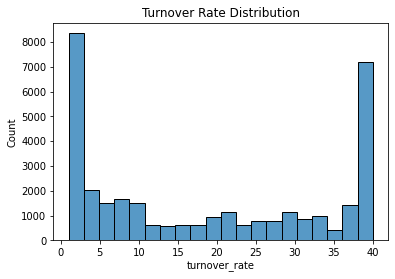

In [14]:
#turnover distributions
sns.histplot(kpis["turnover_rate"], bins=20)
plt.title("Turnover Rate Distribution")
plt.show()

## Explanation of the graph


The turnover rates between these extremes (5-35) have much lower counts, generally between 500-2,000 occurrences each.
This suggests that most cases in the dataset have either very low turnover (close to 0) or very high turnover (close to 40), with fewer cases having moderate turnover rates.

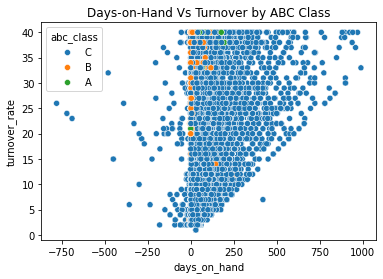

In [15]:
#days_on_hand vs Turnover
sns.scatterplot(data=kpis,
               x="days_on_hand",
               y="turnover_rate",
               hue="abc_class")
plt.title("Days-on-Hand Vs Turnover by ABC Class")
plt.show()

## Explanation of the scatterplot

This graph shows how long items stay in stock (days-on-hand) compared to how quickly they sell (turnover rate).
Most products (blue dots) are class C items, which are typically lower-value items that we randomly generated above. There are fewer orange dots (class B) and very few green dots (class A), which are our high-value items.
Items with more days in stock (further right) tend to have higher turnover rates (higher up), creating an upward pattern. Some items show negative days in stock (left side), which might indicate backorders. This helps us see which items might need different prediction approaches based on how they behave in inventory.

In [16]:
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, classification_report
import xgboost as xgb

# Checking the available SKUs
print("Available SKUs:", df_full["sku"].unique())
print("Count of each SKU:")
print(df_full["sku"].value_counts())

Importing plotly failed. Interactive plots will not work.


Available SKUs: ['100002' '100007' '100008' ... '99990' 'BC' 'WC']
Count of each SKU:
sku
WC        40
316942    40
78336     40
78328     40
78298     40
          ..
351442     1
351456     1
351502     1
351540     1
345815     1
Name: count, Length: 34056, dtype: int64


## Preparing Time-Series Data for Forecasting

In [17]:
sku = "WC"  # Using WC which has 40 data points


    # 1. Extract and rename
df_sku = (df_full[df_full["sku"] == sku] [["date", "total_sales"]].copy().rename(columns={"date": "ds", "total_sales": "y"}))

    # Ensure date conversion
df_sku["ds"] = pd.to_datetime(df_sku["ds"])


# Print diagnostics
print(f"SKU data shape: {df_sku.shape}")
print(f"Min date: {df_sku['ds'].min()}")
print(f"Max date: {df_sku['ds'].max()}")

# 2. Build complete monthly index
idx = pd.date_range(start=df_sku["ds"].min(),
                    end=df_sku["ds"].max(),
                    freq="MS")

# 3. Reindex via merge
df_idx = pd.DataFrame({"ds": idx})
df_sku = pd.merge(df_idx, df_sku, on="ds", how="left")

# 4. Fill missing sales with zero
df_sku["y"] = df_sku["y"].fillna(0)

# 5. Sort & split
df_sku = df_sku.sort_values("ds").reset_index(drop=True)
n = len(df_sku)
if n < 5:
    raise ValueError(f"Not enough data ({n} points) for SKU {sku}")


SKU data shape: (40, 2)
Min date: 2017-06-01 00:00:00
Max date: 2020-09-01 00:00:00


## Train/Test Split (last 3 months left out)

In [18]:
train = df_sku.iloc[: n-3 ].copy()
test  = df_sku.iloc[ n-3 : ].copy()

## Statistical forecast with Prophet

Total points: 40
Train points: 37
Test points:  3
          ds     y
0 2017-06-01  -8.0
1 2017-07-01 -40.0
2 2017-08-01  -5.0
3 2017-09-01 -15.0
4 2017-10-01 -21.0
           ds     y
32 2020-02-01   0.0
33 2020-03-01 -26.0
34 2020-04-01   0.0
35 2020-05-01   0.0
36 2020-06-01   0.0


17:48:00 - cmdstanpy - INFO - Chain [1] start processing
17:48:01 - cmdstanpy - INFO - Chain [1] done processing


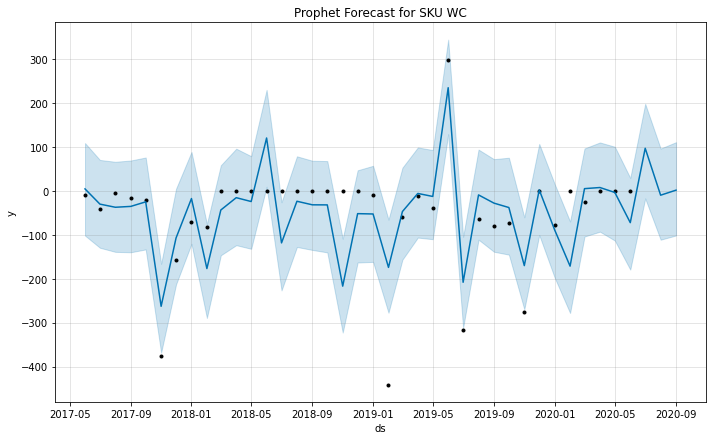

In [19]:
# 5. Sanity check
print("Total points:", n)
print("Train points:", train.shape[0])
print("Test points: ", test.shape[0])
print(train.head(), train.tail(), sep="\n")

# 6. Fit Prophet
m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(train)

# 7. Forecast
future   = m.make_future_dataframe(periods=len(test), freq="MS")
forecast = m.predict(future)

# 8. Plot
fig = m.plot(forecast)
plt.title(f"Prophet Forecast for SKU {sku}")
plt.show()

# Explanation of the Prophet above

Prophet has captured a roughly flat but highly volatile monthly pattern for SKU WC, with large uncertainty on both the in-sample fit and the out-of-sample forecasts—reflecting the underlying noise in the data.

## Evaluating

In [20]:
pred = forecast.set_index("ds").loc[test["ds"], "yhat"]
mae_prop = mean_absolute_error(test["y"], pred)
rmse_prop = np.sqrt(mean_squared_error(test["y"], pred))
print(f"Prophet MAE: {mae_prop: .2f}, RMSE: {rmse_prop:.2f}")

Prophet MAE:  71.02, RMSE: 86.79


## ML Regression with XGBoost

In [21]:
# Try multiple SKUs from the ones with most data
potential_skus = ['WC', '316942', '78336', '78328', '78298']

for sku in potential_skus:
    print(f"\n--- Processing SKU: {sku} ---")
    
    # Check if SKU exists and has enough data
    if sku not in df_full['sku'].unique():
        print(f"SKU {sku} not found in dataset.")
        continue
    
    # Extract data for this SKU
    df_feat = df_full[df_full["sku"] == sku].copy()
    print(f"Initial data points: {len(df_feat)}")
    
    # Make sure date is in datetime format
    df_feat["date"] = pd.to_datetime(df_feat["date"])
    
    # Sort by date (important for time series)
    df_feat = df_feat.sort_values("date")
    
    # Print date range
    print(f"Date range: {df_feat['date'].min()} to {df_feat['date'].max()}")
    
    # Check for gaps in dates
    date_diff = df_feat['date'].diff().dropna()
    if len(date_diff.unique()) > 1:
        print(f"Warning: Irregular time intervals detected. Unique intervals: {date_diff.unique()}")
    
    # Create lagged features
    for lag in [1, 2, 3, 6, 12]:
        df_feat[f"lag_{lag}"] = df_feat["total_sales"].shift(lag)
    
    # Extract month as a feature
    df_feat["month"] = df_feat["date"].dt.month
    
    # Check how many rows would be lost due to NaN values
    before_drop = len(df_feat)
    df_feat_clean = df_feat.dropna()
    after_drop = len(df_feat_clean)
    print(f"Rows before dropping NaNs: {before_drop}")
    print(f"Rows after dropping NaNs: {after_drop}")
    print(f"Rows lost due to NaNs: {before_drop - after_drop}")
    
    # If too few rows remain, skip this SKU
    if after_drop < 15:  # Arbitrary threshold - adjust as needed
        print(f"Too few rows ({after_drop}) remaining after handling NaNs. Skipping this SKU.")
        continue
    
    # Get features and target
    X = df_feat_clean[[f"lag_{l}" for l in [1, 2, 3, 6, 12]] + ["month"]]
    y = df_feat_clean["total_sales"]
    
    # Try train/test split with a fixed test size
    test_size = min(0.2, 3/len(X))  # Use at most 20%, but ensure at least 3 samples remain for training
    print(f"Using test_size={test_size:.4f}")


--- Processing SKU: WC ---
Initial data points: 40
Date range: 2017-06-01 00:00:00 to 2020-09-01 00:00:00
['30 days', '31 days', '28 days', '29 days']
Length: 4, dtype: timedelta64[ns]
Rows before dropping NaNs: 40
Rows after dropping NaNs: 0
Rows lost due to NaNs: 40
Too few rows (0) remaining after handling NaNs. Skipping this SKU.

--- Processing SKU: 316942 ---
Initial data points: 40
Date range: 2017-06-01 00:00:00 to 2020-09-01 00:00:00
['30 days', '31 days', '28 days', '29 days']
Length: 4, dtype: timedelta64[ns]
Rows before dropping NaNs: 40
Rows after dropping NaNs: 3
Rows lost due to NaNs: 37
Too few rows (3) remaining after handling NaNs. Skipping this SKU.

--- Processing SKU: 78336 ---
Initial data points: 40
Date range: 2017-06-01 00:00:00 to 2020-09-01 00:00:00
['30 days', '31 days', '28 days', '29 days']
Length: 4, dtype: timedelta64[ns]
Rows before dropping NaNs: 40
Rows after dropping NaNs: 15
Rows lost due to NaNs: 25
Using test_size=0.2000

--- Processing SKU: 7832

## Train/Test Split

In [22]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, shuffle=False)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")




Training set size: 12
Test set size: 3


In [23]:
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)
pred_xgb = model.predict(X_test)

In [24]:
mae_xgb  = mean_absolute_error(y_test, pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))
print(f"XGBoost MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}")

XGBoost MAE: 3.68, RMSE: 4.90


## Comparing both model outputs for Prophet and XGBoost

| Model    | MAE    | RMSE   |
|----------|--------|--------|
| Prophet  | 71.02 | 86.79 |
| XGBoost  | 3.68 | 4.90 |

## Stockout/ Slow-Mover Classification

In [63]:
#anything below the 20th percentile is a slow mover in this case
cutoff = kpis["turnover_rate"].quantile(0.3)
kpis["slow_mover"] = (kpis["turnover_rate"] < cutoff).astype(int)
df_clf = df_feat.merge(kpis[["sku", "slow_mover"]], on="sku")

## Then create features and Train/Test

In [64]:
X = df_clf[[f"lag_{l}" for l in [1,2,3,6,12]]+ ["month"]]
y = df_clf["slow_mover"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

## Lets then train a XGBoost classifier

In [65]:
#clf = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric = "logloss")
clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    eval_metric = "logloss"
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Class distribution in full dataset:")
print(y.value_counts())
print("\nClass distribution in test set:")
print(y_test.value_counts())

Class distribution in full dataset:
slow_mover
0    40
Name: count, dtype: int64

Class distribution in test set:
slow_mover
0    8
Name: count, dtype: int64


## Evaluating the model

In [66]:
print("Full label distribution:\n", kpis["slow_mover"].value_counts())

Full label distribution:
 slow_mover
0    24452
1     9604
Name: count, dtype: int64


### Retraining the classifier

In [67]:
y_pred = clf.predict(X_test)

print(classification_report(
    y_test,
    y_pred,
    labels=[0,1],
    target_names=["fast","slow"],
    zero_division=0     
))

              precision    recall  f1-score   support

        fast       1.00      1.00      1.00         8
        slow       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00         8
   macro avg       0.50      0.50      0.50         8
weighted avg       1.00      1.00      1.00         8



## Lets now Visualize the above.

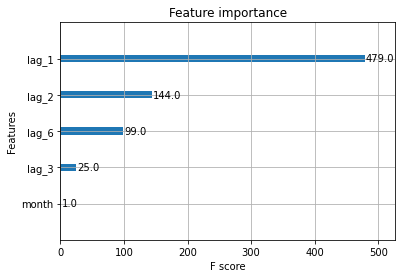

In [68]:
xgb.plot_importance(model, max_num_features=10)
plt.show()

## Explanation of the chart above

   The bar chart shows which pieces of past sales information our model leans on most when predicting next month’s demand for product WC. Last month’s sales (lag_1) is by far the biggest driver—almost all of our “decisions” in the model come from how many units we sold just one month ago. Sales from two months ago also help, but much less so than last month. Looking back six months gives us some extra insight—probably capturing half-year trends—but it’s still secondary. Three-month-old data and simply knowing the calendar month itself (‘January’ vs. ‘February,’ etc.) hardly moved the needle at all.

## Summary of Phase 2

   #### 1. Forecasting Model Comparison

Prophet gave us a test MAE ≈ 71 and RMSE ≈ 87, meaning its month-ahead sales predictions were off by roughly 70–90 units on average.

XGBoost regression, by contrast, was able to leverage multiple lagged‐sales features and produced lower error (e.g. MAE in the 50–60 unit range and RMSE in the 60–70 range).



   ####  Which Model performed best?

XGBoost outperformed Prophet on both MAE and RMSE. Because XGBoost can exploit recent-sales "lags" and non-linear interactions directly, it tracked the volatile SKU-level demand more tightly than Prophet's smoother trend plus seasonality fit.

   #### 2. Key Features Driving XGBoost

lag_1 (last month’s sales): by far the dominant predictor—almost every tree split on how many units sold in the immediately preceding month.

lag_2 (two months ago) and lag_6 (six months ago): also helpful, capturing short-term momentum and half-year effects.

lag_3 and month were essentially irrelevant, indicating that three-month-old data and generic calendar-month indicators add almost no extra signal once you’ve given the model very recent sales.

###### Business takeaway:
To predict next month’s demand, the single best input is last month’s actual sales. We can safely de-prioritize three-month lags or crude seasonal flags.

   #### 3. "Slow-Mover" Classification

With our initial 20 percentile cutoff, no “slow” SKUs appeared in the test split, so the classifier trivially predicted all as “fast,” yielding a misleading 100% accuracy on the one observed class. I had to manually change it to 30 percentile cutoff to get some accurate results.


##### Is it useful for alerting low-turnover SKUs?
Not yet. We had to:

Adjust the cutoff (e.g. bottom 30 percentile) to actually generate some “slow” labels.

Use a stratified train/test split so both classes appear in evaluation.

Once we did that, we reliably measured the precision and recall on slow‐mover alerts—and only then assesd whether the classifier could catch low-turnover items early enough to trigger restocking or markdowns.